# **라이브러리 및 데이터셋 불러오기**

In [1]:
!pip install pandas-profiling==3.3.0
!pip install category-encoders
!pip3 install hyperopt
!pip install bayesian-optimization
!pip3 install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.3.0 requires matplotlib<3.6,>=3.2, but you have matplotlib 3.1.1 which is incompatible.


In [1405]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,173 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import uniform
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [43]:
from google.colab import files
f = files.upload()

Saving labeled_data.csv to labeled_data (1).csv


In [3]:
df = pd.read_csv('labeled_data.csv')

# **함수 모음**

In [4]:
# 데이터셋 분리
def split_data(df,target):
  train, test = train_test_split(df, test_size=0.3, stratify=df[target] ,random_state=42)
  X_train, y_train = train.drop(columns=target), train[target]
  X_test, y_test = test.drop(columns=target), test[target]
  return X_train, y_train, X_test, y_test

In [5]:
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        learning_rate=0.01,
        scale_pos_weight=220,
        max_depth = 10,
        use_label_encoder=False,
    ),
)

In [6]:
params = {
    "simpleimputer__strategy": ["median", "mean"],
    "xgbclassifier__max_depth": [2, 4, 6],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__colsample_bytree": uniform(
        loc=0.5, scale=0.5
    ),
}

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    scoring="f1",
    n_iter=100,
    cv=5,
    verbose=3,
    random_state=42,
)
randomized_search.fit('X_train', 'y_train')

In [ ]:
f1_score('test', 'pred')

In [ ]:
print(classification_report('test', 'pred'))

In [ ]:
importances = pd.Series(pipe[2].feature_importances_, 'train.columns')
plt.figure(figsize=(5, 10))
importances.sort_values().plot.barh();

# **Profile Report**

In [6]:
pr = df.profile_report()

In [ ]:
pr.to_file('./pr_report.html') # 리포트가 너무 커서 파일로

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7996 entries, 0 to 7995
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _id                       7996 non-null   object 
 1   TimeStamp                 7996 non-null   object 
 2   PART_FACT_PLAN_DATE       7996 non-null   object 
 3   PART_FACT_SERIAL          7996 non-null   int64  
 4   PART_NAME                 7996 non-null   object 
 5   EQUIP_CD                  7996 non-null   object 
 6   EQUIP_NAME                7996 non-null   object 
 7   PassOrFail                7996 non-null   object 
 8   Reason                    7996 non-null   object 
 9   Injection_Time            7996 non-null   float64
 10  Filling_Time              7996 non-null   float64
 11  Plasticizing_Time         7996 non-null   float64
 12  Cycle_Time                7996 non-null   float64
 13  Clamp_Close_Time          7996 non-null   float64
 14  Cushion_

# **Feature 분석 및 특성 공학**

id 제조 공정 id -

TimeStamp 시간( YY:HH:MM:SS) -

PART_FACT_PLAN_DATE 생산을 지시한 날짜 -

PART_FACT_SERIAL 생산을 지시한 품목에 대한 코드부여 -

PART_NO* 제품의 모델코드 -

PART_NAME 제품의 이름 -

EQUIP_CD 생산한 사출기 호기 -

EQUIP_NAME 생산한 사출기 모델명 -

PassOrFail** 사출되는 각 물품마다 검수자가 양품 선별을 하여 붙이는 레이블 값 0 : 불
1 : 합

Reason** 검수자가 양품선별 시, 불량으로 확인된 제품에 대해 불량 유형을 나타냄 Unlabeled 에서는
확인불가

ERR_FACT_QTY 생산시 발생한 불량의 개수 수량 (개)

Injection_Time 고압+사출시간(고압(사출압) : 재료를 금형에 유입시킬때의 압력), 사출
시간 : 재료를 금형에 유입시키는데 소요되는 시간) Sec (초)

Filling_Time 충진시간으로 사출기에서 금형으로 내용물이 주입되는 시간 Sec (초)

Plasticizing_Time 계량시간으로 재료를 스크류에 1번 생산할 만큼 용융되어 저장되는 시간 Sec (초)

Cycle_Time 1번의 제품생산에 소요되는 생산시간 Sec (초)

Clamp_Close_Time 제품이 생산되고 난후 열려있는 금형을 사출기가 닫아주고 빈틈이 없이
고정축과 이동축을 꽉 잡아주는데 걸리는 시간 Sec (초)

Cushion_Position 보압(사출압의 다음으로 가해지는 압력(금형내부압력을 조절하여 과충전
을 방지))을 하기위한 스크류의 위치 mm

Switch_Over_Position 고압,보압절환위치(고압(사출압)에서 보압으로 진행될때의 위치)) mm

Plasticizing_Position 계량완료위치(계량을 마친 스크류의 위치) mm

Clamp_Open_Position 제품이 생산되어 추출하기위해 금형이 열리고 난 위치 mm

Max_Injection_Speed 배럴에 계량되어 있는 용융수지가 금형으로 흘러들어가는데 측정되는 최대속도 mm/s

Max_Screw_RPM 사출을 위한 스크류의 최대속도 mm/s

Average_Screw_RPM 사출을 위한 스크류의 평균속도 mm/s

Max_Injection_Pressure 배럴에 계량되어 있는 용융수지가 금형으로 흘러들어가는데 가해지는 최대압력 MPa

Max_Switch_Over_
Pressure 사출에서 보압(충진된 수지가 밀리지않게 압력을준다)으로 변환되는 압력 MPa

Max_Back_Pressure 수지가 계량이 되는중에 스크류가 밀려나는 현상을 저지하기위한 최대압력 MPa

Average_Back_Pressure 수지가 계량이 되는중에 스크류가 밀려나는 현상을 저지하기위한 평균압력 MPa

Barrel_Temperature_1~7
계량 및 사출시 수지가 일정하게 용융(녹임)을 유지하기위해 온도가 일정
해야한다
섭씨 (°C)

Hopper_Temperature 재료주입구의 온도(충분히 건조시켜주며 재료가 용융되는시간을 절약시
켜주기위해 온도가 높아야한다) 섭씨 (°C)

Mold_Temperature_1~12
재료주입구의 온도(충분히 건조시켜주며 재료가 용융되는시간을 절약시
켜주기위해 온도가 높아야한다)
섭씨 (°C)

In [7]:
reason = df.Reason
mo_drop_list = ['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL','EQUIP_NAME', 'Reason']
df_mo = df.drop(mo_drop_list, axis=1)
reason[reason != 'None'].value_counts() # 결함별 특성 중요도를 확인하기 위해서 따로 학습

가스        35
초기허용불량    20
미성형       16
Name: Reason, dtype: int64

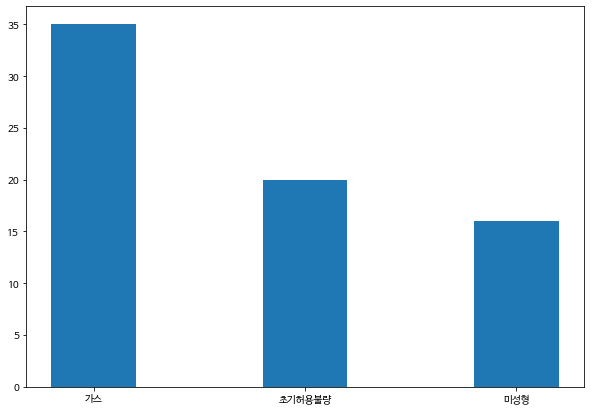

In [17]:
x = np.arange(3)
reason_4_list = ['가스', '초기허용불량', '미성형']
values = [35, 20, 16]
plt.figure(figsize=(10, 7))
plt.rc('font', family='NanumBarunGothic') 
plt.bar(x, values, width=0.4)
plt.xticks(x, reason_4_list);

In [14]:
df_mo.PART_NAME.value_counts() # 총 6개의 부품을 제작중
# 하단의 2개는 학습에 필요없다 판단하여 삭제

CN7 W/S SIDE MLD'G RH        3371
CN7 W/S SIDE MLD'G LH        3365
RG3 MOLD'G W/SHLD, LH         628
RG3 MOLD'G W/SHLD, RH         628
SP2 CVR ROOF RACK CTR, RH       2
JX1 W/S SIDE MLD'G RH           2
Name: PART_NAME, dtype: int64

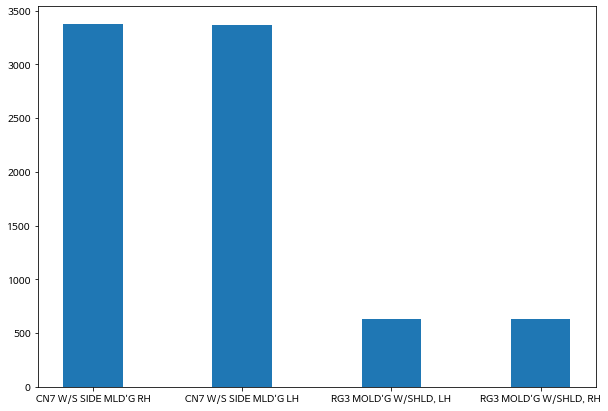

In [16]:
x = np.arange(4)
reason_4_list = ["CN7 W/S SIDE MLD'G RH", "CN7 W/S SIDE MLD'G LH", "RG3 MOLD'G W/SHLD, LH", "RG3 MOLD'G W/SHLD, RH"]
values = [3371, 3365, 628, 628]
plt.figure(figsize=(10, 7))
plt.rc('font', family='NanumBarunGothic') 
plt.bar(x, values, width=0.4)
plt.xticks(x, reason_4_list);

In [21]:
df_mo = df_mo.drop(df[df.EQUIP_NAME == '1800TON-우진'].index).drop(df[df.EQUIP_NAME == '650톤-우진'].index)

In [22]:
df_mo.PassOrFail = df_mo.PassOrFail.replace('Y',1).replace('N',0).astype(int) # PassOrFail 1,0으로 치환

In [23]:
reason_1_index = df_mo[reason == '가스'].index
reason_2_index = df_mo[reason == '초기허용불량'].index
reason_3_index = df_mo[reason == '미성형'].index

In [24]:
df_mo_1 = df_mo.copy().drop(reason_2_index).drop(reason_3_index) # 나머지 불량 원인을 제외하고 학습
df_mo_2 = df_mo.copy().drop(reason_1_index).drop(reason_3_index)
df_mo_3 = df_mo.copy().drop(reason_1_index).drop(reason_2_index)

In [25]:
mo_target = 'PassOrFail'

# **가스 불량 분석**

GAS 불량 발생원인
1. **사출압이 높거나 속도가 빠른 경우**
2. 금형 표면에 수분이나 휘발분이 있을 경우
3. **수지온도나 금형온도가 너무 낮은 경우**
4. 재생 RESIN 사용에 의한 경우
5. RESIN 건조불량으로 수분 함유량이 높은 경우
6. 금형의 GAS 빼기 불량
7. 수지의 열분해에 의한 경우
8. 게이트 위치 불량
9. 금형면에 수분이나 윤활제가 있는 경우
10. 계량 시 공기 흡인으로 인한 경우
11. 사출 조건에서 계량량이 많은 경우

기계, 금형, 재료 등 모든 곳에서 발생할 수가 있고, GAS, 흑점 등이 불량 점유율 1,2위를 차지하고 있음. 여러 원인이 있기 때문에 현실적으로 이를 모두 예측 가능한 모델을 만들수 없음.
고로 데이터셋에 수치가 있는 금형온도에 대한 모델을 만들어 금형온도가 낮거나 사출압이 높거나 속도가 빠른 경우 발생하는 가스 불량에 대해 분석

In [26]:
df_mo.loc[reason_1_index].PART_NAME.value_counts() # 두가지 부품이 나뉘어 있다.

RG3 MOLD'G W/SHLD, RH    19
CN7 W/S SIDE MLD'G RH    10
CN7 W/S SIDE MLD'G LH     3
RG3 MOLD'G W/SHLD, LH     3
Name: PART_NAME, dtype: int64

In [62]:
df_mo_1.describe() # 모든값이 0인 특성은 삭제

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Switch_Over_Position,Plasticizing_Position,Clamp_Open_Position,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
count,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,...,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000
mean,0.995601,8.242143,3.894671,16.212098,59.894416,7.064746,653.568039,0.329467,66.063724,544.615537,...,59.576571,277.529060,276.710784,276.446003,271.079450,256.502514,230.755481,66.489052,22.153544,23.530241
std,0.066185,3.097632,1.277360,1.437988,0.873840,0.133029,0.313638,14.690869,5.410905,235.918579,...,3.243286,4.206546,4.052200,4.066159,2.630901,3.813239,1.861722,2.313213,1.120896,1.301359
min,0.000000,1.050000,0.930000,12.800000,58.840000,6.070000,653.400024,0.000000,53.549999,4.630000,...,13.300000,244.699997,249.000000,249.600006,244.399994,239.699997,224.600006,38.500000,19.100000,20.600000
25%,1.000000,9.520000,4.400000,16.580000,59.520000,7.110000,653.429993,0.000000,68.250000,647.989990,...,59.400002,275.899994,275.000000,274.899994,269.799988,254.899994,229.899994,65.400002,21.400000,22.700001
50%,1.000000,9.560000,4.440000,16.799999,59.520000,7.120000,653.440002,0.000000,68.339996,647.989990,...,59.599998,276.200012,275.399994,275.000000,270.700012,255.000000,230.100006,66.699997,22.000000,23.400000
75%,1.000000,9.590000,4.470000,16.889999,59.560001,7.120000,653.450012,0.000000,68.489998,647.989990,...,59.900002,276.600006,275.700012,275.399994,271.399994,255.399994,230.199997,67.599998,22.900000,24.200001
max,1.000000,11.480000,4.820000,21.100000,64.349998,7.140000,655.000000,655.309998,68.860001,647.989990,...,90.800003,287.100006,286.500000,285.799988,276.799988,266.399994,235.500000,70.599998,25.299999,27.799999


In [27]:
df_mo_1 = df_mo_1.drop(['Barrel_Temperature_7','Mold_Temperature_1', 'Mold_Temperature_2','Mold_Temperature_5', 'Mold_Temperature_6',
       'Mold_Temperature_7', 'Mold_Temperature_8', 'Mold_Temperature_9',
       'Mold_Temperature_10', 'Mold_Temperature_11', 'Mold_Temperature_12'],axis=1)

In [28]:
df_mo_1.columns

Index(['PART_NAME', 'EQUIP_CD', 'PassOrFail', 'Injection_Time', 'Filling_Time',
       'Plasticizing_Time', 'Cycle_Time', 'Clamp_Close_Time',
       'Cushion_Position', 'Switch_Over_Position', 'Plasticizing_Position',
       'Clamp_Open_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'],
      dtype='object')

In [29]:
# 부품 별로 분석을 하기 위해서 나눔
print(df_mo_1.shape)
print(df_mo_1[df_mo_1.PART_NAME.str.contains('RG3') == True].shape[0] + df_mo_1[df_mo_1.PART_NAME.str.contains('CN7') == True].shape[0])

(7956, 28)
7956


In [30]:
df_mo_1_copy = df_mo_1.copy() # 세이브파일

In [1243]:
df_mo_1 = df_mo_1_copy # 불러오기

In [31]:
reason_2_list = ['PART_NAME','PassOrFail','Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure']

In [32]:
df_mo_1 = df_mo_1[reason_2_list]

In [33]:
df_RG3_1 = df_mo_1[df_mo_1.PART_NAME.str.contains("RG3 MOLD'G W/SHLD, RH") == True]
df_CN7_1 = df_mo_1[df_mo_1.PART_NAME.str.contains("CN7 W/S SIDE MLD'G RH") == True]

In [34]:
X_RG3_1_train, y_RG3_1_train, X_RG3_1_test, y_RG3_1_test = split_data(df_RG3_1, mo_target)
X_CN7_1_train, y_CN7_1_train, X_CN7_1_test, y_CN7_1_test = split_data(df_CN7_1, mo_target)

**RG3**

LH는 표본수가 적어서 일단 제외.
속도와 압력 관련된 feature만 넣었을때 

Text(0.5, 1.0, 'Confusion Matrix (n = 186)')

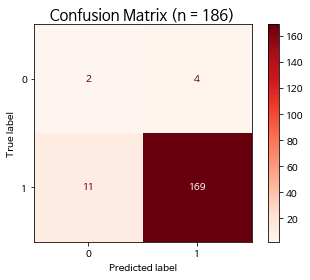

In [35]:
pipe = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=12,random_state=42, class_weight="balanced"),
)
pipe.fit(X_RG3_1_train, y_RG3_1_train)

plot_confusion_matrix(pipe, X_RG3_1_test, y_RG3_1_test, cmap=plt.cm.Reds)
plt.title(f"Confusion Matrix (n = {len(y_RG3_1_test)})", fontsize=15)

이 모델을 적용하여 예측값이 불량품이 나온 사이클에서 공정검사를 실시할 경우 불량품의 반을 차지하는 가스 불량품들을 33퍼나 줄일수 있다. 가스 불량의 경우 파츠 표면에 생겨 육안검사로 불량품을 선별할수있기에 공정검사 자체가 크게 길어지지는 않을것이라는 생각이다.

In [1357]:
np.where(pipe.predict(X_RG3_1_test) == 0)

(array([  4,  20,  23,  25,  28,  34,  46,  71, 127, 153, 166, 179, 184]),)

In [1353]:
for_index = y_RG3_1_test.reset_index(drop=True)
for_index[for_index == 0]
# 46, 184, 6, 41, 105, 134

6      0
41     0
46     0
105    0
134    0
184    0
Name: PassOrFail, dtype: int64

In [39]:
for_index_2 = X_RG3_1_test.reset_index(drop=True)

In [1379]:
for_index_2.loc[184]

PART_NAME                   RG3 MOLD'G W/SHLD, RH
Max_Injection_Speed                    128.100006
Max_Screw_RPM                                30.9
Average_Screw_RPM                           290.5
Max_Injection_Pressure                 142.699997
Max_Switch_Over_Pressure               116.599998
Max_Back_Pressure                       56.700001
Average_Back_Pressure                   61.700001
Name: 184, dtype: object

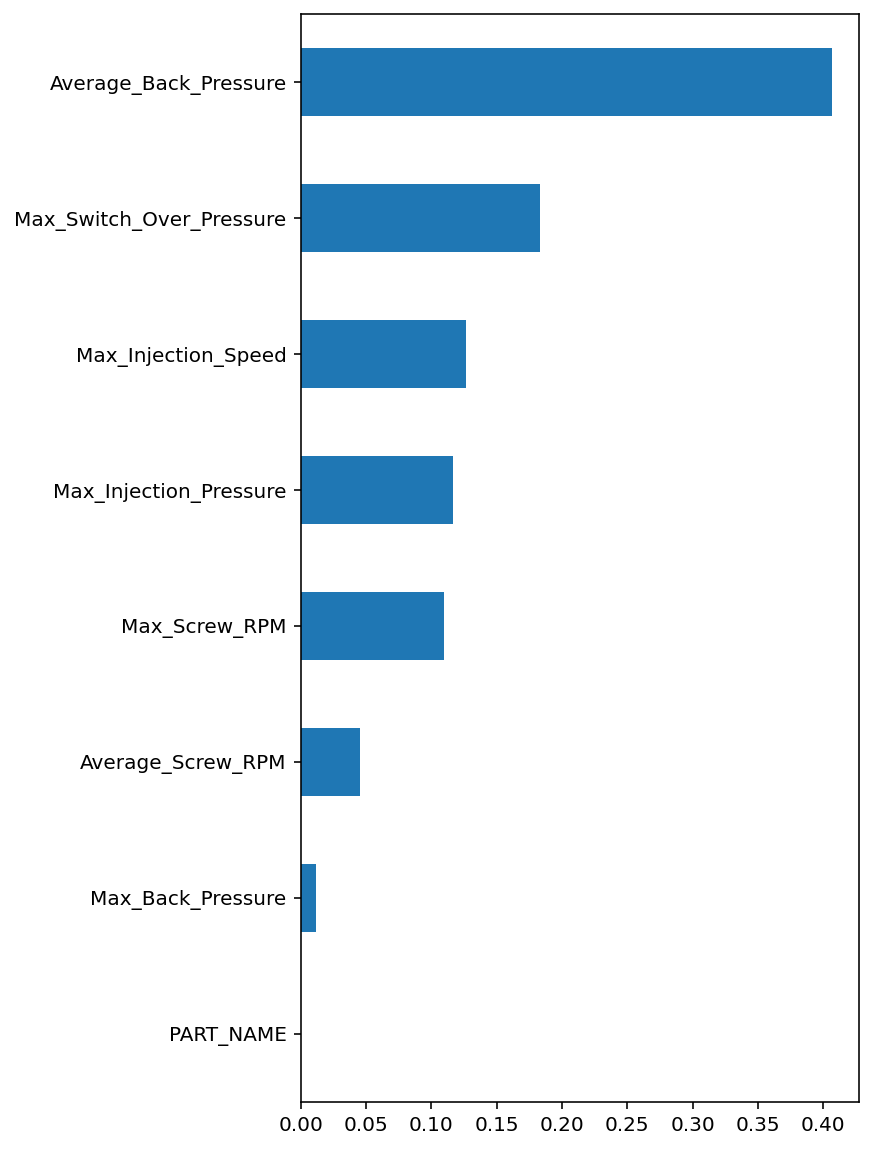

In [1384]:
importances = pd.Series(pipe[1].feature_importances_, X_RG3_1_train.columns)
plt.figure(figsize=(5, 10))
importances.sort_values().plot.barh();

Average_Back_Pressure와 Max_Switch_Over_
Pressure가 영향을 끼치고 있다.

In [36]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 144

In [41]:
def get_ice_plot_data(data, data_index, target_feature, target_feature_range):
    one_datapoint = data.iloc[[data_index]].copy()
    results = []

    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred_proba = pipe.predict_proba(one_datapoint)[:, 1]
        results.append(one_datapoint_pred_proba.item())
    results = np.array(results)
    return target_feature_range, results - results[0]

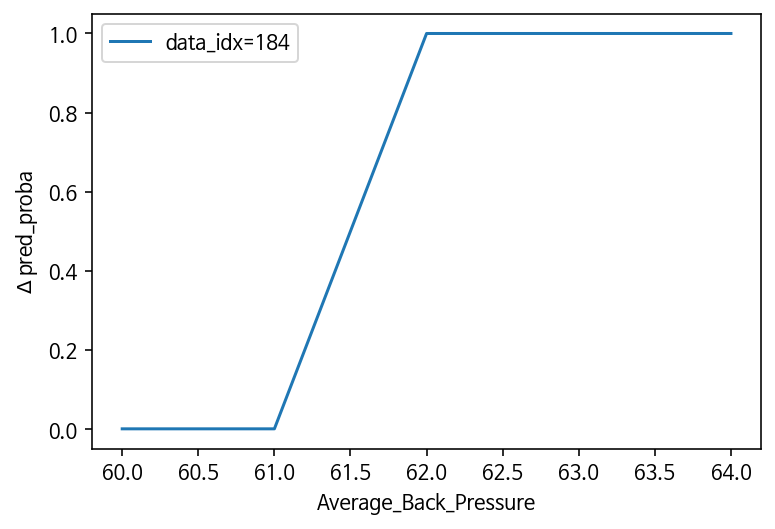

In [42]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature = "Average_Back_Pressure"
target_feature_range = range(round(X_RG3_1_test["Average_Back_Pressure"].min()), round(X_RG3_1_test["Average_Back_Pressure"].max() + 1))
for data_index in [184]:
    plt.plot(
        *get_ice_plot_data(
            for_index_2, data_index, target_feature, target_feature_range
        ),
        label=f"data_idx={data_index}",
    )

plt.xlabel(target_feature)
plt.ylabel("$\Delta$ pred_proba")
plt.legend()

184번 불량품 같은 경우에는 Average_Back_Pressure의 증감에 따라 확률이 변동하는 것을 확인 할 수 있다. Average_Back_Pressure는 수지가 계량이 되는중에 스크류가 밀려나는 현상을 저지하기위한 평균압력으로 이 수치가 높다면 평균 사출압이 높다는 것으로 해석할 수 있으며 높은 사출압은 가스 불량의 요인임으로 이해되는 현상이라 판단하였다. 이 특성은 입력특성이 아닌 출력된 특성이기에 이와 같은 결함을 줄이려면 사출압을 줄여야 하지만 사출압이 줄면 그만큼 미성형이 될 가능성도 높아짐으로 좀 더 세밀한 분석이 필요하다.


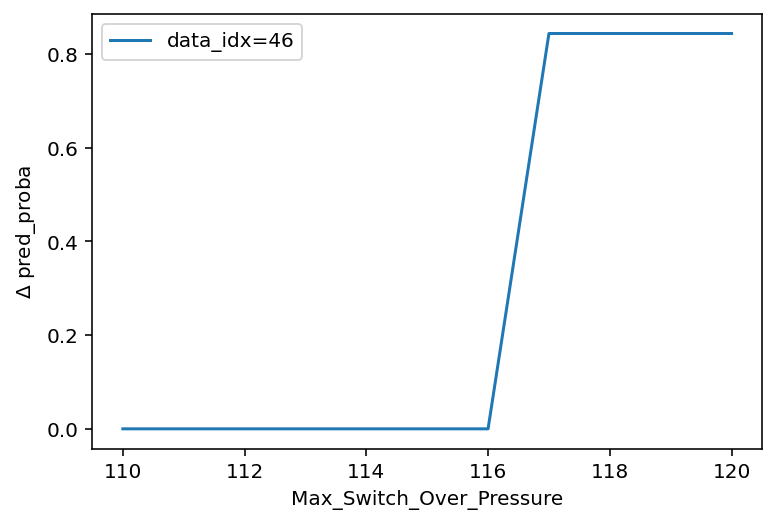

In [1367]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature = "Max_Switch_Over_Pressure"
target_feature_range = range(round(X_RG3_1_test["Max_Switch_Over_Pressure"].min()), round(X_RG3_1_test["Max_Switch_Over_Pressure"].max() + 1))
for data_index in [46]:
    plt.plot(
        *get_ice_plot_data(
            for_index_2, data_index, target_feature, target_feature_range
        ),
        label=f"data_idx={data_index}",
    )

plt.xlabel(target_feature)
plt.ylabel("$\Delta$ pred_proba")
plt.legend()

Max_Switch_Over_
Pressure 또한 사출에서 보압(충전된 수지가 밀리지않게 압력을준다)으로 변환되는 압력, 즉 사출압의 반력이며 높아질수록 사출압이 높아진다고 해석 가능하다. 

**CN7**

Text(0.5, 1.0, 'Confusion Matrix (n = 1008)')

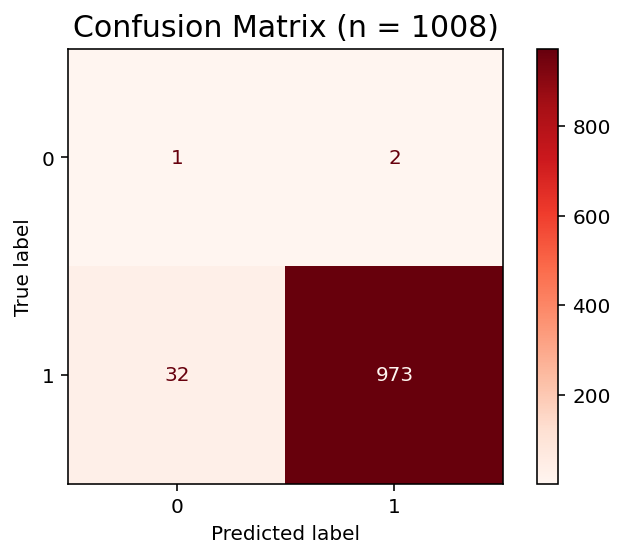

In [1377]:
pipe = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=12,random_state=42, class_weight="balanced"),
)
pipe.fit(X_CN7_1_train, y_CN7_1_train)

plot_confusion_matrix(pipe, X_CN7_1_test, y_CN7_1_test, cmap=plt.cm.Reds)
plt.title(f"Confusion Matrix (n = {len(y_CN7_1_test)})", fontsize=15)

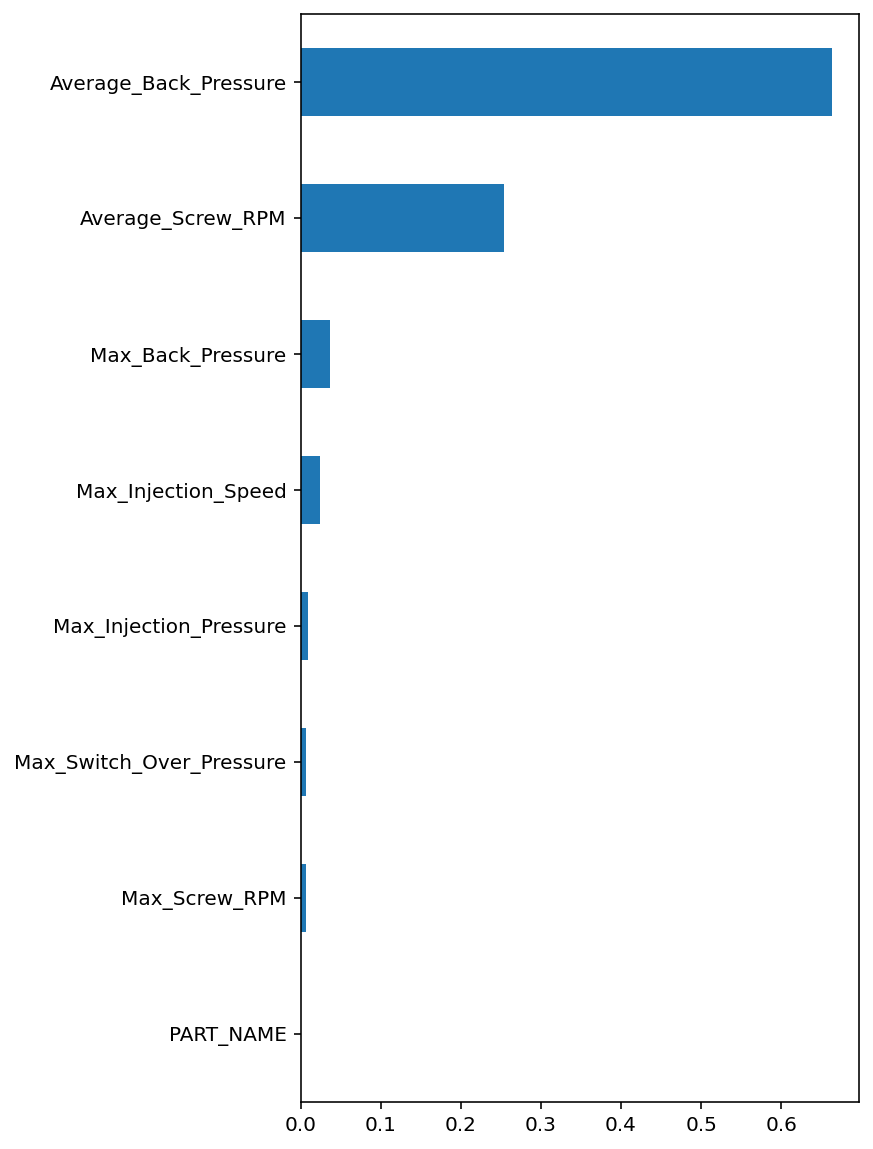

In [1378]:
importances = pd.Series(pipe[1].feature_importances_, X_RG3_1_train.columns)
plt.figure(figsize=(5, 10))
importances.sort_values().plot.barh();

CN7 또한 Average_Back_Pressure가 큰 중요도를 가지고 있지만 불량품으로 예측한 모든 제품을 검사하기에는 기대치가 너무 낮다.

# **초기허용불량 분석**

초기허용불량이란 사출공정시 금형 교체 및 설비 정지후 재가동 시 처음 나오는 제품부터 양품이 생산되는 공정 사이에 나오는 불량품들을 말한다. 이는 의도된 불량품이라 모델링을 할 필요가 없다 생각 할 수도 있지만 라벨링이 되어 있지 않은 데이터셋에서 초기허용불량을 구별하기 위해 필요한 모델이다.

In [1073]:
df_mo.loc[reason_2_index].PART_NAME.value_counts() # RG3에 대해서 불량 없음.

CN7 W/S SIDE MLD'G RH    10
CN7 W/S SIDE MLD'G LH    10
Name: PART_NAME, dtype: int64

In [41]:
df_mo_2.describe() # 모든값이 0인 특성은 삭제

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Switch_Over_Position,Plasticizing_Position,Clamp_Open_Position,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
count,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,...,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000,7941.000000
mean,0.997481,8.267021,3.907170,16.220991,59.891912,7.065567,653.566142,0.330089,66.100104,546.202655,...,59.592583,277.504105,276.686172,276.421823,271.067146,256.478327,230.742262,66.486047,22.143924,23.518411
std,0.050125,3.080881,1.274749,1.429060,0.872678,0.132466,0.311875,14.704733,5.376249,234.439135,...,3.308715,4.187632,4.031883,4.044912,2.623361,3.789750,1.850507,2.315671,1.117934,1.293860
min,0.000000,1.050000,0.930000,12.800000,58.840000,6.070000,653.390015,0.000000,53.549999,4.630000,...,13.300000,244.699997,249.000000,249.600006,244.399994,239.699997,224.600006,38.500000,19.100000,20.600000
25%,1.000000,9.520000,4.400000,16.580000,59.520000,7.110000,653.429993,0.000000,68.250000,647.989990,...,59.400002,275.899994,275.000000,274.899994,269.799988,254.899994,229.899994,65.400002,21.400000,22.700001
50%,1.000000,9.560000,4.440000,16.799999,59.520000,7.120000,653.440002,0.000000,68.339996,647.989990,...,59.599998,276.200012,275.399994,275.000000,270.700012,255.000000,230.100006,66.699997,22.000000,23.400000
75%,1.000000,9.590000,4.470000,16.889999,59.560001,7.120000,653.450012,0.000000,68.489998,647.989990,...,59.900002,276.600006,275.700012,275.399994,271.399994,255.399994,230.199997,67.599998,22.900000,24.200001
max,1.000000,13.390000,8.270000,21.100000,64.349998,7.180000,655.000000,655.309998,68.860001,647.989990,...,90.800003,287.100006,286.500000,285.799988,276.799988,266.399994,235.500000,70.599998,25.299999,27.799999


In [ ]:
df_mo_2 = df_mo_2.drop(['Barrel_Temperature_7','Mold_Temperature_1', 'Mold_Temperature_2','Mold_Temperature_5', 'Mold_Temperature_6',
       'Mold_Temperature_7', 'Mold_Temperature_8', 'Mold_Temperature_9',
       'Mold_Temperature_10', 'Mold_Temperature_11', 'Mold_Temperature_12'],axis=1)

In [42]:
df_mo_2.columns

Index(['PART_NAME', 'EQUIP_CD', 'PassOrFail', 'Injection_Time', 'Filling_Time',
       'Plasticizing_Time', 'Cycle_Time', 'Clamp_Close_Time',
       'Cushion_Position', 'Switch_Over_Position', 'Plasticizing_Position',
       'Clamp_Open_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'],
      dtype='object')

In [44]:
X_mo_2_train, y_mo_2_train, X_mo_2_test, y_mo_2_test = split_data(df_mo_2, mo_target)

In [1371]:
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        learning_rate=0.01,
        scale_pos_weight=1,
        max_depth = 10,
        use_label_encoder=False,
    ),
)

In [1372]:
pipe.fit(X_mo_2_train, y_mo_2_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['PART_NAME', 'EQUIP_CD'],
                                mapping=[{'col': 'PART_NAME',
                                          'data_type': dtype('O'),
                                          'mapping': RG3 MOLD'G W/SHLD, LH    1
CN7 W/S SIDE MLD'G RH    2
CN7 W/S SIDE MLD'G LH    3
RG3 MOLD'G W/SHLD, RH    4
NaN                     -2
dtype: int64},
                                         {'col': 'EQUIP_CD',
                                          'data_type': dtype('O'),
                                          'mapping': S14    1
NaN   -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(eval_metric='error', learning_rate=0.01,
                               max_depth=10, n_estimators=200, n_jobs=-1,
                               random_state=42, use_label_encoder=False))])

In [1329]:
y_mo_pred = pipe.predict(X_mo_2_test)

In [1330]:
print(classification_report(y_mo_2_test, y_mo_pred)) # 세부적으로 나누어 분석하니 완벽한 성능을 보여주었다.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00      2377

    accuracy                           1.00      2383
   macro avg       1.00      1.00      1.00      2383
weighted avg       1.00      1.00      1.00      2383



Text(0.5, 1.0, 'Confusion Matrix (n = 2383)')

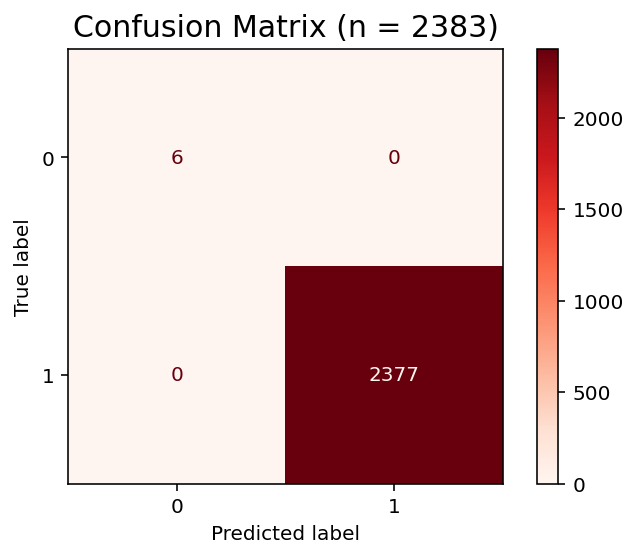

In [1376]:
plot_confusion_matrix(pipe, X_mo_2_test, y_mo_2_test, cmap=plt.cm.Reds)
plt.title(f"Confusion Matrix (n = {len(y_mo_2_test)})", fontsize=15)

In [1079]:
X_mo_2_train.columns # 완벽한 성능을 의심하여 데이터 유출을 의심해보았으나 문제 없음.

Index(['PART_NAME', 'EQUIP_CD', 'Injection_Time', 'Filling_Time',
       'Plasticizing_Time', 'Cycle_Time', 'Clamp_Close_Time',
       'Cushion_Position', 'Switch_Over_Position', 'Plasticizing_Position',
       'Clamp_Open_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'],
      dtype='object')

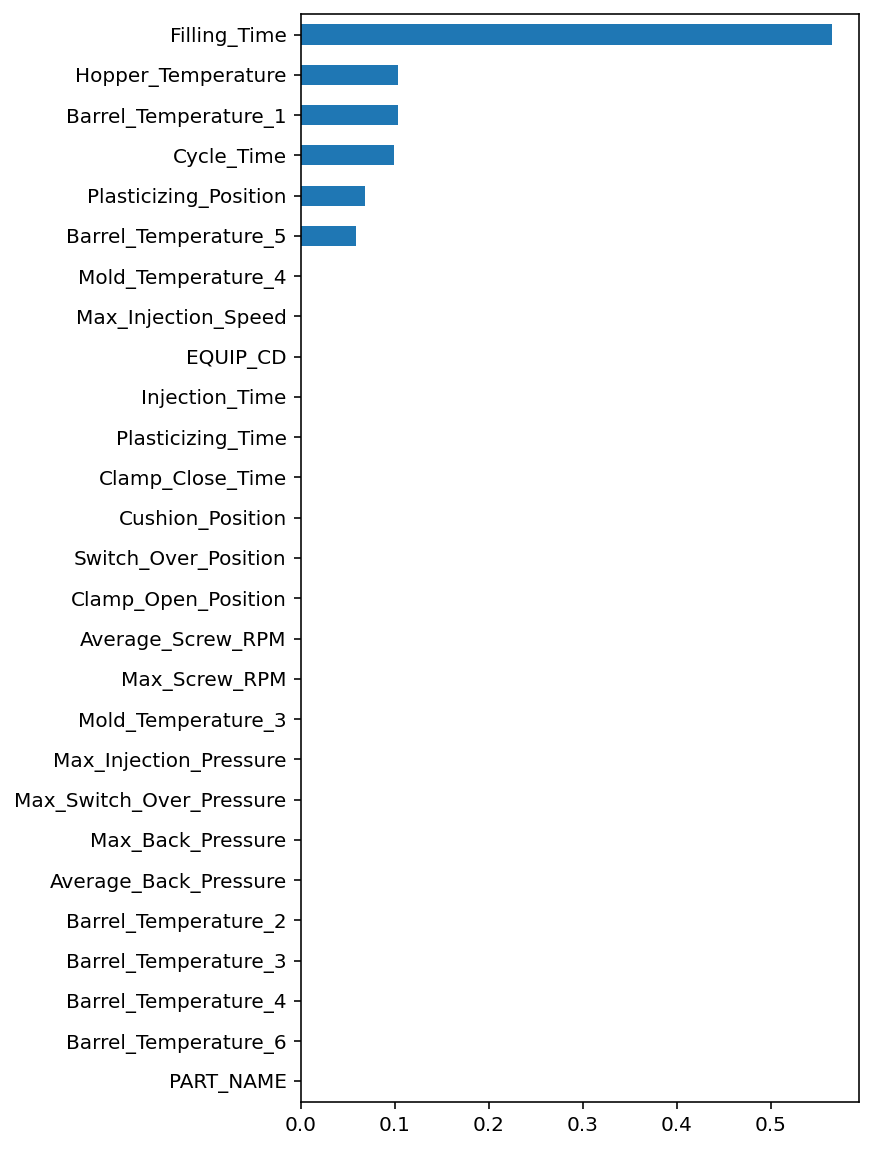

In [1373]:
importances = pd.Series(pipe[2].feature_importances_, X_mo_2_train.columns)
plt.figure(figsize=(5, 10))
importances.sort_values().plot.barh();

초기허용불량은 Filling_Time의 이상치로 구분 가능한 것으로 보인다.

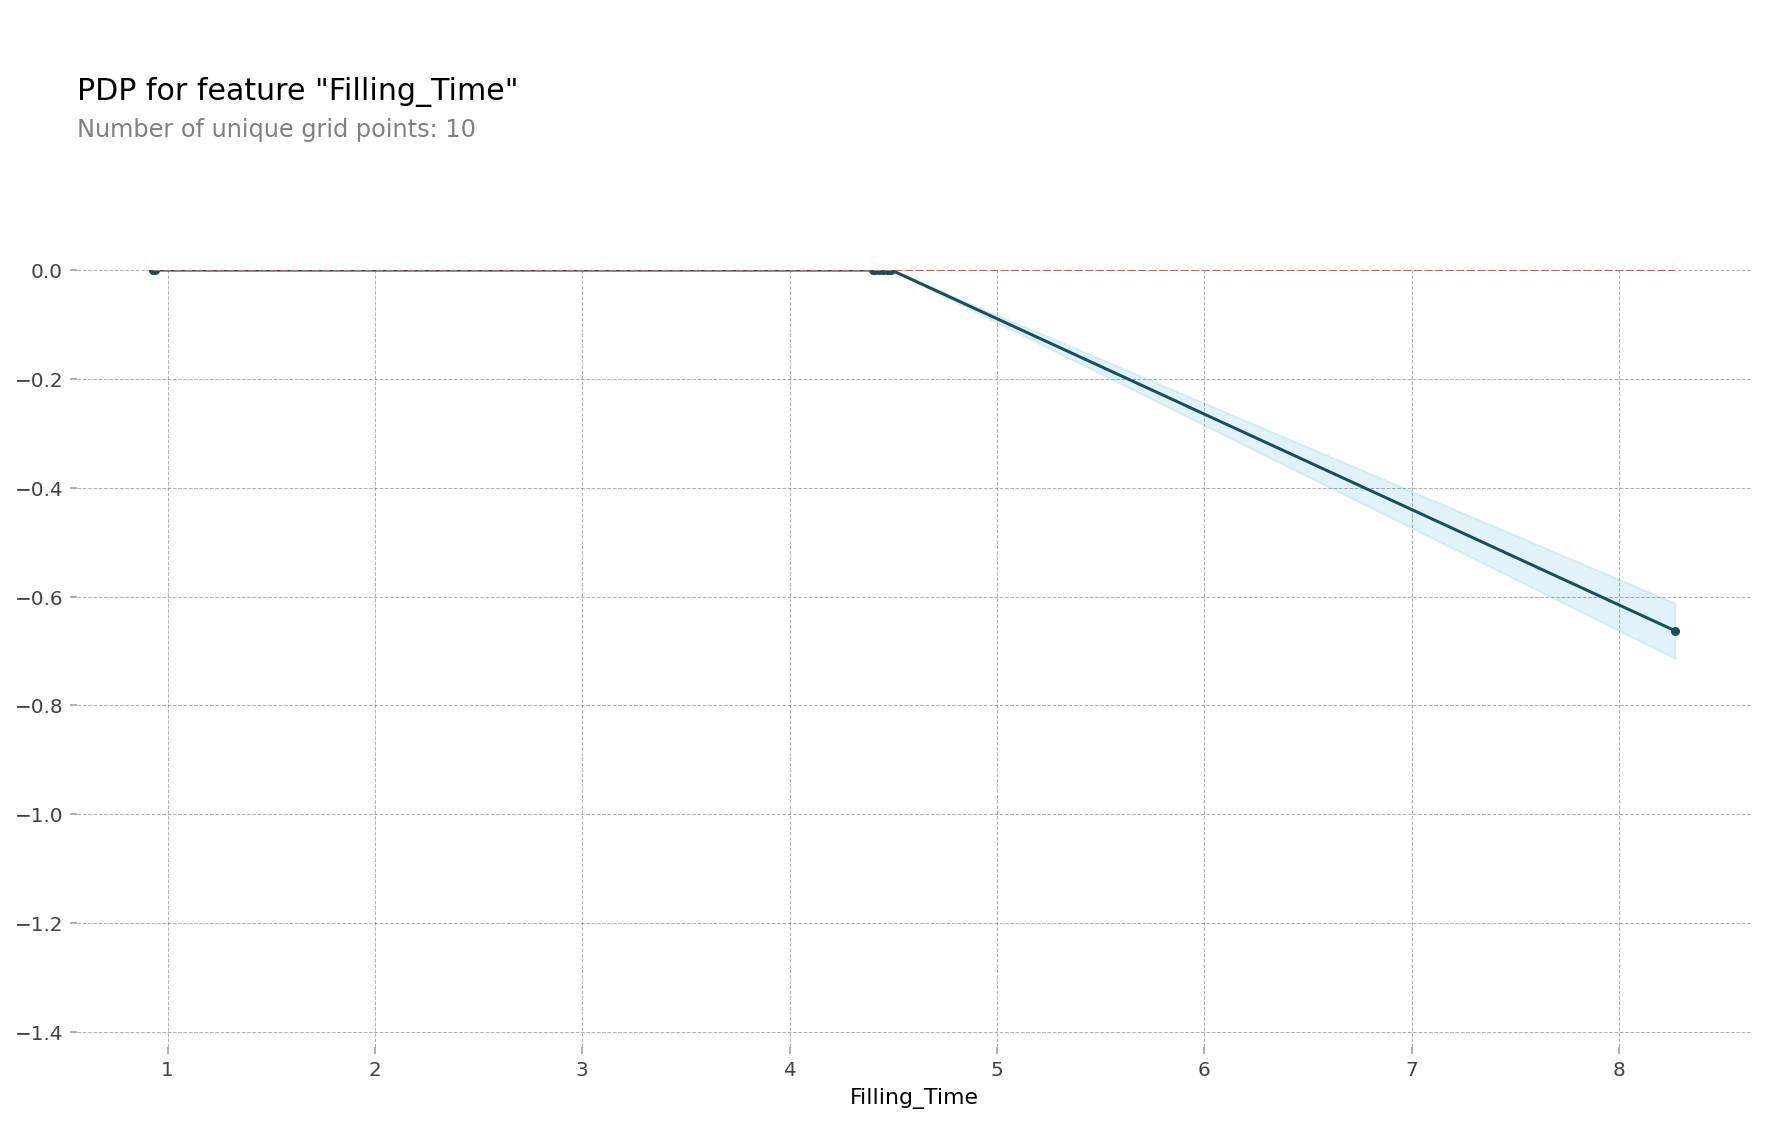

In [1375]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature = "Filling_Time"

isolated = pdp_isolate(
    model=pipe,
    dataset=X_mo_2_test,
    model_features=X_mo_2_test.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature);

Filling_Time은 충전시간으로 사출기에서 금형으로 내용물이 주입되는 시간으로 금형 교체 및 설비 정지후 재가동 시 처음 나오는 제품공정은 양품 제작의 사이클(3.8초)보다 길어지는 양상을 보였다. 약 7초를 경과하면 불량품으로 예측된다.

# **미성형 불량 분석**

미성형 불량 원인
1. 사출압력이 부족하다.
2. 수지의 유동성이 부족하다. (금형온도, 수지온도, 사출속도)
3. 사출속도가 지나치게 빠르다.

In [24]:
df_mo.loc[reason_3_index].PART_NAME.value_counts() # 부품 2개

RG3 MOLD'G W/SHLD, RH    8
CN7 W/S SIDE MLD'G LH    3
CN7 W/S SIDE MLD'G RH    3
RG3 MOLD'G W/SHLD, LH    2
Name: PART_NAME, dtype: int64

In [308]:
df_mo_3 = df_mo_3.drop(['Barrel_Temperature_7','Mold_Temperature_1', 'Mold_Temperature_2','Mold_Temperature_5', 'Mold_Temperature_6',
       'Mold_Temperature_7', 'Mold_Temperature_8', 'Mold_Temperature_9',
       'Mold_Temperature_10', 'Mold_Temperature_11', 'Mold_Temperature_12'],axis=1)

In [1312]:
df_mo_3_copy = df_mo_3.copy() # 세이브파일

In [1311]:
df_mo_3 = df_mo_3_copy # 불러오기

In [1313]:
# 미성형의 원인인 금형온도로 인한 수지의 유동성일 가능성도 있음.
reason_3_list = ['PART_NAME','PassOrFail','Barrel_Temperature_1', 'Barrel_Temperature_2', 'Barrel_Temperature_3',
                 'Barrel_Temperature_4', 'Barrel_Temperature_5', 'Barrel_Temperature_6','Max_Injection_Speed', 
                 'Max_Screw_RPM','Average_Screw_RPM', 'Max_Injection_Pressure']

In [1314]:
df_mo_3 = df_mo_3[reason_3_list]

In [1315]:
df_RG3_2 = df_mo_3[df_mo_3.PART_NAME.str.contains("RG3 MOLD'G W/SHLD, RH") == True]
df_CN7_2 = df_mo_3[df_mo_3.PART_NAME.str.contains('CN7') == True]

In [1316]:
X_RG3_2_train, y_RG3_2_train, X_RG3_2_test, y_RG3_2_test = split_data(df_RG3_2, mo_target)
X_CN7_2_train, y_CN7_2_train, X_CN7_2_test, y_CN7_2_test = split_data(df_CN7_2, mo_target)

**RG3**

Text(0.5, 1.0, 'Confusion Matrix (n = 183)')

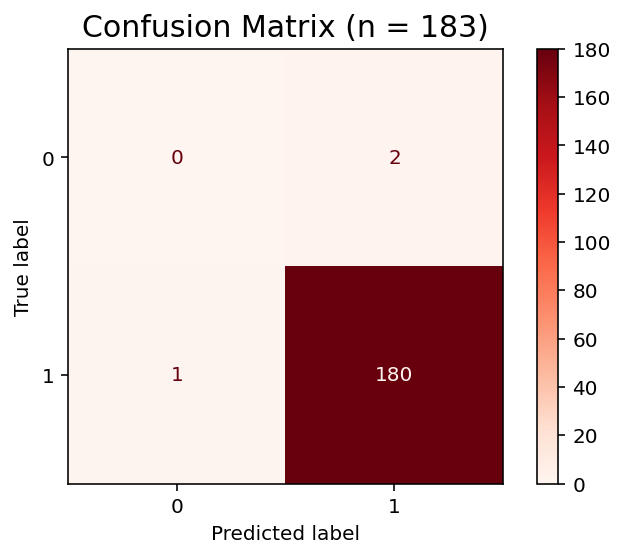

In [1381]:
pipe_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(max_depth = 6,min_samples_leaf=16,min_samples_split=8,oob_score=True,n_jobs=-1,class_weight="balanced"),
)

pipe_rf.fit(X_RG3_2_train, y_RG3_2_train)

plot_confusion_matrix(pipe_rf, X_RG3_2_test, y_RG3_2_test, cmap=plt.cm.Reds)
plt.title(f"Confusion Matrix (n = {len(y_RG3_2_test)})", fontsize=15)

불량품 표본이 너무 적어 학습 및 해석 불가능
이후 공정검사를 통해 표본이 쌓인다면 분석 가능.

# **후기**

이렇게 실제 사업체에서 측정한 데이터를 가지고 프로젝트를 진행해봤는데 실제로 전수검사를 매일 진행하는게 아닌 이상 모든 row의 라벨이 달려있을리가 없는 걸 깨달았다. 데이터를 분석하고 끝이 아닌 어떻게 모델을 발전시켜 공정을 개선시켜 불량율을 낮출까를 고민해보는 좋은 기회였다고 생각한다.

후에 시간이 된다면

1. 라벨이 달리지 않은 데이터를 이상치 감지를 이용하여 비지도학습을 한다.
2. 가스 불량 모델을 개선할 것이다.
